#Data Preprocessing

In [ ]:
#Step 1 – Data Preprocessing
import pandas as pd

#Load the training data
df = pd.read_csv("data_train.csv")
print("Initial shape:", df.shape)

#Drop duplicate rows
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

#Drop the 'Id' column (not useful for modelling)
df = df.drop(columns=["Id"])

#Rename column 'Married/Single' to 'Marital_Status'
df = df.rename(columns={"Married/Single": "Marital_Status"})

#Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

#Check data types
print("\nData types:")
print(df.dtypes)

#Preview the cleaned data
df.head()


Initial shape: (232000, 13)
Shape after dropping duplicates: (232000, 13)

Missing values per column:
Income               0
Age                  0
Experience           0
Marital_Status       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

Data types:
Income                int64
Age                   int64
Experience            int64
Marital_Status       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object


,Income,Age,Experience,Marital_Status,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,3078173,59,12,single,rented,yes,Librarian,Parbhani,Maharashtra,9,10,1
1,962072,25,14,single,rented,yes,Consultant,Phagwara,Punjab,4,11,0
2,6272029,49,12,single,rented,no,Drafter,Sagar,Madhya_Pradesh,7,10,0
3,3315074,72,14,single,rented,no,Software_Developer,Thoothukudi,Tamil_Nadu,8,13,0
4,9078449,79,10,single,owned,yes,Designer,Danapur,Bihar,8,10,0


In [ ]:
# Export cleaned data for Tableau EDA
df.to_csv("cleaned_train_data.csv", index=False)
print("✅ Cleaned data exported for Tableau: cleaned_train_data.csv")


✅ Cleaned data exported for Tableau: cleaned_train_data.csv


#Analysis of Machine Learning Models




In [ ]:
#Step 3 – Model Training and Evaluation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [ ]:
#Load the cleaned dataset
df = pd.read_csv("cleaned_train_data.csv")

In [ ]:
#Separate target and features
X = df.drop(columns=["Risk_Flag", "CITY", "STATE", "Profession"])
y = df["Risk_Flag"]

In [ ]:
#Identify categorical and numeric columns
categorical_cols = ["Marital_Status", "House_Ownership", "Car_Ownership"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [ ]:
#Preprocessing: One-hot encode categoricals, scale numerics
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

In [ ]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
#Define models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [ ]:
#Train and evaluate each model
results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_val)
    y_prob = pipe.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "AUC": round(auc, 4),
        "F1 Score": round(f1, 4)
    })



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:09:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
#Show results

results_df = pd.DataFrame(results).sort_values("F1 Score", ascending=False)
print(results_df)

                 Model  Accuracy     AUC  F1 Score
1        Random Forest    0.8993  0.9371    0.5714
2              XGBoost    0.8855  0.8655    0.2452
0  Logistic Regression    0.8771  0.5495    0.0000


#Model Explainability

In [ ]:
#Step 4 – SHAP Explainability for Random Forest
import shap
import numpy as np
import matplotlib.pyplot as plt

#Sample 1,000 rows from validation set
X_shap_sample = X_val.sample(n=1000, random_state=42)

#Extract the preprocessing step from pipeline
X_shap_prepared = preprocessor.transform(X_shap_sample)



In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(preprocessor.transform(X_train), y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

In [ ]:
#Compute SHAP values
shap_values = explainer.shap_values(X_shap_prepared)

In [ ]:
#Get feature names
encoded_feature_names = preprocessor.get_feature_names_out()

In [ ]:
#Create a DataFrame with proper column names
X_shap_df = pd.DataFrame(X_shap_prepared.toarray() if hasattr(X_shap_prepared, "toarray") else X_shap_prepared,
                         columns=encoded_feature_names)

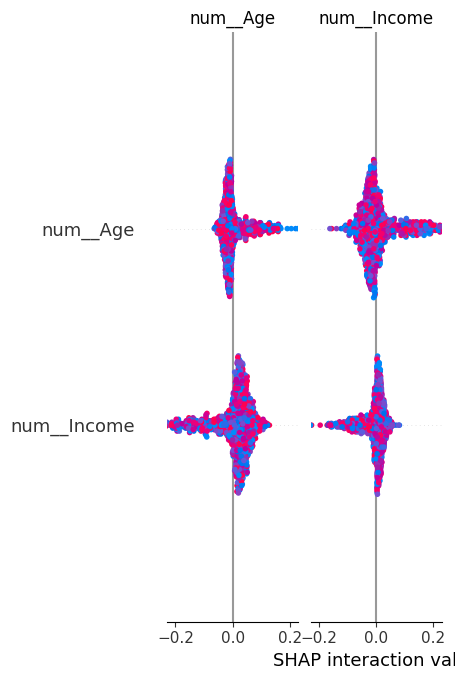

In [ ]:
#Summary plot – global importance (bar chart)
shap.summary_plot(shap_values, X_shap_df, plot_type="bar", show=True)

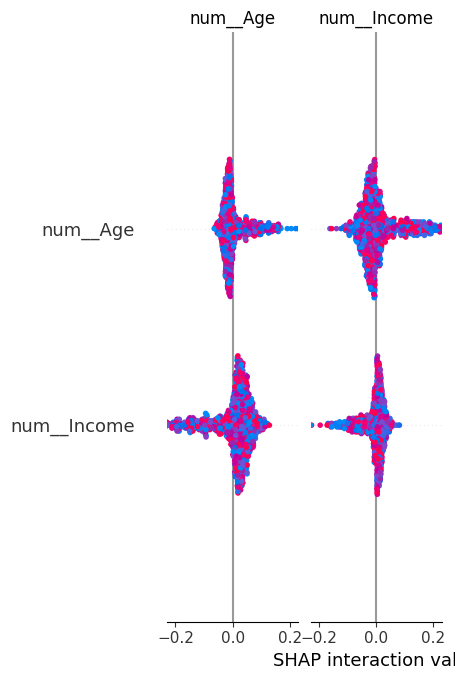

In [ ]:
#Beeswarm plot – feature effects (scatter)
shap.summary_plot(shap_values, X_shap_df, show=True)